# Neural Search

Nachdem ich ein bisschen erkundet habe, denke ich, dass ich ungefähr weiß, was ich für diese Programme beachten muss. Deshalb werden die nächsten beiden Aufgaben folgende sein:
1. NN implementieren (torch) und in vorherigem environment testen
2. Code präsentierbar machen

## NN Implementieren
Wir versuchen das Ganze in zwei Schritten anzugehen. Zunächst möchte ich ein sehr simples Model ausprobieren:
1.  Programmiere ein einfaches neuronales Netz.
    - Die Inputneuronen sind Ringförmig um den Agenten angeordnet. Jedes Neuron erhält einen Input von 1 (oder abhängig von Einnahme des Beobachtungsfeldes), wenn mindestens ein Ziel in der Winkelregion des Neurons ist.
    - Mit einem einfachen Feedforward Layer und Aktivierungen wie in dem vorherigen Versuch wird die Aktivierung des Netzwerkes ausgerechnet

2. Nachdem sich herausgestellt hat, dass das Ganze doch nicht so simpel ist, ist es erstmal Zeit die Ergebnisse zusammenzufassen:
    - Wir definieren eine Klasse `NeuralAgent`, welche die Bewegung eines Agenten steuert.
    Der Agent wird an einer Position $x=0 \in \mathbb{C}$ initialisiert. Er führt `n_steps` Schritte durch, welche durch die Funktion `step()` beschrieben werden. 
    Schritte werden wie folgt bestimmt: 
        - Der Agent besitzt `n_neurons` Neuronen, welche jeweils eine bestimmte Richtung kodieren. Jedes Neuron hat eine Aktivierung $\in [0, \infty)$, welche die Präferenz des Agenten in die korrespondierende Richtung angibt. Die Aktivierung setzt sich aus einer `base_activation` und den Interaktion zwischen Neuronen zusammen.
        Die Interaktion zwischen Neuronen ist durch $W_{ij}= \cos\left(\pi \left(\frac{|\theta_{ij}|}{\pi}\right)^{\nu}\right)$ gegeben.
        - Zunächst wäre ein Ansatz mit der `base_activation` zu starten und dann solange die Aktivierungen durch $A_{n+1} = WA_n$ zu iterieren, bis wir in ein Equilibrium gelangen. Dabei treten aber mehrere Probleme auf:
        $(WA_n)_i$ ist nicht notwendigerweise $\in [0,1]$. Insbesondere können negative und größere Werte auftreten. Dies kann behoben werden (ReLU1 Aktivierung), aber ein weiteres Problem ist, dass es keine Präferenz für bestimmte Ziele gibt. 

        - Ein zweiter Ansatz wäre eine binäre Aktivierung der Neuronen zu verwenden (Hopfield Network) $A_i \in \{-1, 1\}$. Dies erscheint mir gerade vielversprechender.





Nach basic Hopfield, vlt das hier implementieren? https://arxiv.org/abs/2008.02217



Ideen:
Was ist, wenn sich das Ziel plötzlich als nicht essbar entpuppt oder als Feind? Vor allem interessant bei ring attractor search.
Verschiedene Stadien: warten, suchen, essen und Übergänge dazwischen. Wiederkehrende Nahrung
    


In [364]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from typing import NamedTuple

# parameter classes
class Param_Agent(NamedTuple):
    start_pos: torch.Tensor
    start_orientation: float
    vel: float

    n_neurons: int
    angle_modifier: float # nu, the neural tuning parameter from before
    activation_width: float # how far away neurons still get an activation from a target
    target_error: float # error of the target angle for each neuron
    
class Param_Instance(NamedTuple):
    param_agent: Param_Agent
    n_steps: int
    n_agents: int
    n_targets: int
    equi_time: int 
    
    target_init_method: str
    init_dist: float = 1

class Parameter(NamedTuple):
    param_inst: Param_Instance
    n_inst: int

class Generation():
    '''run multiple instances with a given set of parameters and keep track of results'''
    def __init__(self, params:Parameter) -> None:
        self.params = params
        self.num_inst = params.n_inst
        self.instances: list[Instance]

    def sim_gen(self):
        for i, inst in enumerate(self.instances):
            inst.run()
            
class Instance():
    ''' control one Instance of the simulation. Eventually use gpus to speed this up'''
    device = torch.device("cpu")
    def __init__(self, params: Param_Instance) -> None:
        self.params = params
        self.all_targets: torch.Tensor = Instance.init_targets(params.n_targets, params.target_init_method, params)

        self.agents: list[Agent] = [NeuralAgent(params.param_agent, self.all_targets) for i in range(params.n_agents)]
        self.agent_history = torch.zeros(self.params.n_agents, self.params.n_steps, dtype=torch.complex128)

    def run(self):
        for i in range(self.params.n_steps):
            for j, agent in enumerate(self.agents):
                self.agent_history[j,i] = agent.step()

    @staticmethod
    def init_targets(n_targets, init_method, params):
        ''' targets are represented as complex numbers '''
        targets = np.zeros(n_targets, dtype="complex")
        match init_method:
            case "unit_circle":
                # place targets equidistributed on a circle of radius 1
                angles = np.linspace(0, 2*np.pi, n_targets+1)
                targets = params.init_dist *np.exp(1.j*angles[:-1])
            case "half_unit_circle":
                # place targets equidistributed on a half-circle of radius 1
                angles = np.linspace(0, np.pi, n_targets)
                targets = params.init_dist*np.exp(1.j*angles)
            case "random_circle":
                # place them randomly on a circle of radius 1
                angles = 2*np.pi*np.random.uniform(size=n_targets)
                targets = params.init_dist*np.exp(1.j*angles)
            case "full_env":
                # init them by drawing from a 2D normal distribution 
                targets_real = np.random.normal(loc=0, scale=params.init_target_scale, size=(n_targets,2))
                targets = targets_real[...,0] +1j * targets_real[...,1]
        targets = torch.tensor(targets, device=Instance.device)
        return targets 

class Agent():
    def __init__(self, params: Param_Agent) -> None:
        self.params = params

    def step(self):
        pass

class NeuralAgent(Agent):
    def __init__(self, params: Param_Agent, targets) -> None:
        super().__init__(params)
        self.params = params
        self.targets: torch.Tensor = targets
        self.angles, self.activations = self.init_neurons()

        self.weight_matrix = self.init_weights()

        self.pos = self.params.start_pos
        self.vel = self.params.vel

    def __str__(self):
        # describe neural net
        return "Update me!"

    def init_weights(self):
        ''' init the weight matrix based on pairwise angles'''
        pdiff = torch.absolute(self.angles.unsqueeze(1) - self.angles) # pairwise distances between angles
        min_angle = torch.minimum(pdiff, 2*torch.pi - pdiff) 
        J_ij = torch.cos(torch.pi*(min_angle/torch.pi)**self.params.angle_modifier) # weight matrix

        return J_ij
    
    def init_neurons(self):
        '''create neurons and set base activation to 1'''
        angles = torch.linspace(-np.pi, np.pi, self.params.n_neurons+1, dtype=torch.double)
        activations = torch.ones(self.params.n_neurons, dtype=torch.double)

        # create an activation function for the neurons. This activates neurons based on the angle between the neuron and the targets
        normal_std = self.params.activation_width
        activation_func = lambda theta: 1/(normal_std*np.sqrt(2*np.pi))*torch.exp(-1/2*(theta/normal_std)**2)
        max_base_activation = torch.max(activation_func(torch.tensor(np.linspace(0, 2*np.pi)))) # normalization
        self.target_activation_func = lambda theta: 2*activation_func(theta)/max_base_activation
        return angles[:-1], activations
    
    def step(self, equi_time = 100):
        '''perform one step'''
        # first, activate neurons
        self.activate_neurons()

        # then update the neuron weights (until equilibrium)
        self.update_neurons(equi_time)

        # move in average direction of neuron activation
        self.update_position()
        return self.pos
    
    def activate_neurons(self):
        # find the activation the neurons get from the target and multiply by our current activation.
        # Basically, this only allows certain directions to be activated

        pdiff = torch.absolute(self.angles.unsqueeze(1) - torch.angle(self.targets)) # pairwise distances between angles
        min_angles = torch.minimum(pdiff, 2*torch.pi - pdiff) 
        self.activations = torch.mul(self.activations,torch.max(self.target_activation_func(min_angles), dim=1).values)
        return self.activations

    def update_neurons(self, times = 1):
        ''' '''
        for i in range(times):
            # multiply weight matrix with current activation tensor
            new_vec = torch.matmul(self.weight_matrix,self.activations)
            # scale this down
            scaled_vec =self.activations +  new_vec/torch.sum(torch.abs(new_vec))
            #scaled_vec = self.activations + dt*new_vec

            relu = torch.nn.ReLU()
            self.activations = torch.min(torch.tensor([1]), relu(scaled_vec))

            # self.activations= torch.tanh(new_vec)
        return self.activations
    
    def update_position(self):
        angle = torch.angle(torch.sum(self.activations*torch.exp(1j*self.angles)))
        dir = torch.exp(1j*angle)
        self.pos = self.pos + self.vel*dir
        self.targets = self.targets - self.vel*dir
        
    def visualizeNet(self, i=None, mode = "def"):
        '''draw the neural network as well as targets and indicate the neuron activations with colour'''
        if mode == "def" or mode =="def+":
            cmap = colormaps["viridis"]
            neuron_pos = torch.exp(1j*self.angles)
            if i is not None:
                # draw lines from the chosen neuron with colours indicating their interactions
                cmap = colormaps["viridis"]
                for j in range(self.params.n_neurons):
                    if i is not j:
                        # draw a line from neuron i to neuron j and show different color based on weight_matrix
                        color_val = 1/2*(1+self.weight_matrix[i,j])
                        plt.plot([neuron_pos[i].real, neuron_pos[j].real], [neuron_pos[i].imag, neuron_pos[j].imag],color=cmap(color_val))

            else:
                # draw all lines
                for i in range(self.params.n_neurons):
                    for j in range(self.params.n_neurons):
                        if i is not j:
                            # draw a line from neuron i to neuron j and show different color based on weight_matrix
                            color_val = 1/2*(1+self.weight_matrix[i,j])
                            plt.plot([neuron_pos[i].real, neuron_pos[j].real], [neuron_pos[i].imag, neuron_pos[j].imag],color=cmap(color_val),lw=0.1)
        
        if mode == "def+" or mode=="target_activation":
            angles = torch.zeros(len(self.neurons))
            radii = torch.zeros(len(self.neurons))
            for i, neuron in enumerate(self.neurons):
                angles[i] = neuron.pref_angle
                radii[i] = 1 + 1/3*neuron.activate(self.targets)

            points = radii*torch.exp(1j*angles)
            points = torch.cat((points, points[0].reshape(1)))
            
            plt.plot(points.real, points.imag, )
            plt.scatter(torch.exp(1j*angles).real, torch.exp(1j*angles).imag)
            plt.scatter(2*self.targets.real, 2*self.targets.imag)
            
            lim = 3
            plt.xlim([-lim,lim])
            plt.ylim([-lim,lim])
            
        if mode == "curr_state":
            radii = 1 + 1/3*self.activations
            print(radii.shape)
            points = radii*torch.exp(1j*self.angles)
            points = torch.cat((points, points[0].reshape(1)))
            
            plt.plot(points.real, points.imag, )
            #plt.scatter(torch.exp(1j*self.angles).real, torch.exp(1j*self.angles).imag)
            plt.scatter(self.targets.real, self.targets.imag)
            plt.scatter([0], [0])

            lim = 5
            plt.xlim([-lim,lim])
            plt.ylim([-lim,lim])
      


torch.Size([60])
torch.Size([60])


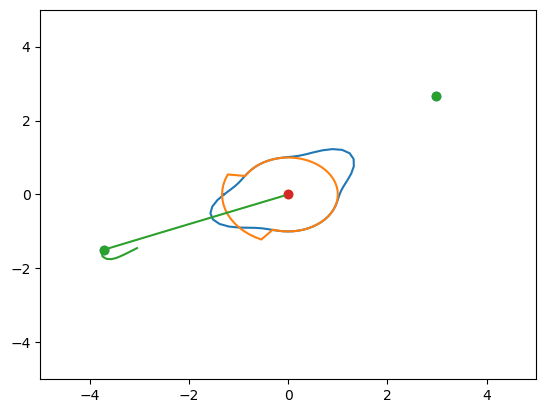

In [373]:

p_agent = Param_Agent(start_pos=torch.tensor(0+0j), start_orientation=0, vel=0.1, n_neurons=60, angle_modifier=0.5, activation_width=0.3, target_error=0.02)
p_inst = Param_Instance(param_agent=p_agent, n_steps=50, n_agents=1, n_targets=2, equi_time=1000, target_init_method="random_circle", init_dist = 4)
inst = Instance(p_inst)
# targets = 4*torch.exp(1j*torch.tensor([0, np.pi*1/3]))
# inst.agents[0].targets = targets
inst.agents[0].activate_neurons()
inst.agents[0].visualizeNet(mode="curr_state")
inst.agents[0].update_neurons(p_inst.equi_time)
inst.agents[0].visualizeNet(mode="curr_state")


inst.run()
hist = inst.agent_history[0]
plt.plot(hist.real, hist.imag)

torch.Size([60])
torch.Size([60])


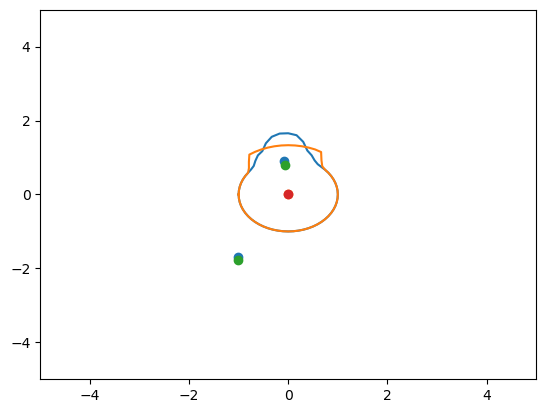

In [196]:
inst.agents[0].activate_neurons()
inst.agents[0].visualizeNet(mode="curr_state")
inst.agents[0].update_neurons(100)

inst.agents[0].step(equi_time = 100)

inst.agents[0].visualizeNet(mode="curr_state")

## Discussion
Hier wird tatsächlich eines der Ergebnisse des Papers reproduziert: Je nach tuning Parameter gibt es einen bestimmen Winkel, den die Ziele vom Agenten aus gesehen haben, ab dem das aktive Feld umschlägt und eine Entscheidung zwischen 2 Zielen fällt.

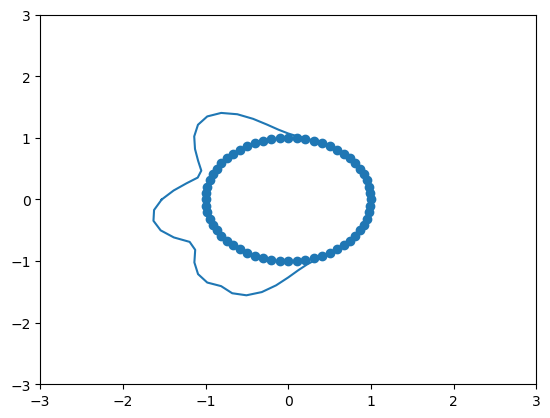

In [147]:
inst.agents[0].visualizeNet(mode="target_activation")


In [148]:

pref_angle = torch.pi*(1/4)

num_targets = 1
target_angle= torch.pi*(-0/4)
target = torch.tensor([np.exp(1j*target_angle)])
# targets = torch.tensor([np.exp(1j*2*torch.pi*i/num_targets) for i in range(num_targets)])

neuron = Neuron(pref_angle)
neuron.activate(target)
# plt.scatter(targets.numpy().real, targets.numpy().imag)
# plt.xlim([-1.5,1.5])
# plt.ylim([-1.5,1.5])

TypeError: Neuron.__init__() missing 1 required positional argument: 'activation_width'

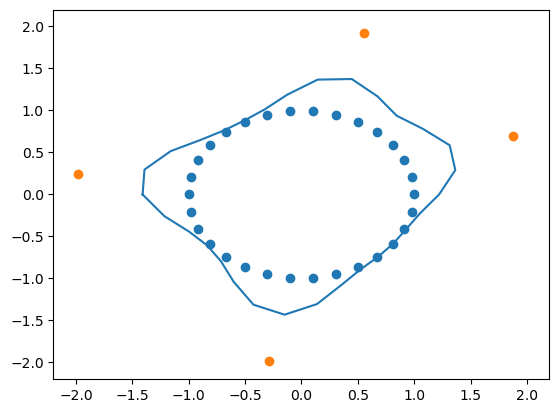

In [ ]:


inst.agents[0].visualizeNet(mode="curr_state")

torch.Size([100])


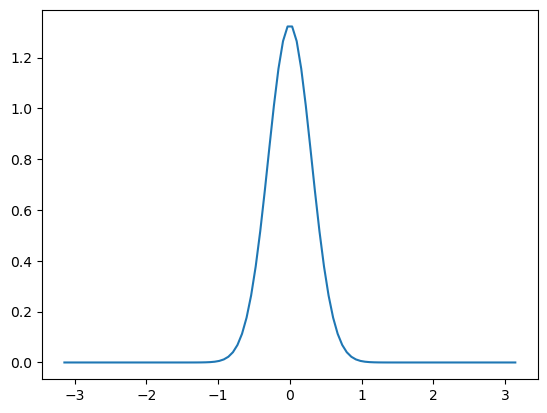

In [ ]:
normal_std = 0.3
activation_func = lambda theta: 1/(normal_std*torch.sqrt(torch.Tensor([2*torch.pi])))*torch.exp(-1/2*(theta/normal_std)**2)
angles = torch.linspace(start=-torch.pi, end=torch.pi, steps=100)
print(angles.shape)
plt.plot(angles, activation_func(angles))

## Kontinuierliches Model
Ich hatte die Idee ein kontinuierliches Modell zu bauen. Dieses soll folgendermaßen funktionieren:
Wir wollen eine Funktion definieren, welche Aktivierungen auf dem Kreis darstellt und sich über die Zeit verändert.

$ A: S^1\times [0,\infty) \rightarrow [0, 1]$

Die Funktion $A(\theta, t)$ soll zur Zeit $t=0$ bestimmt sein. Um die Änderung von $A$ über Zeit zu bestimmen, stellen wir folgende DGL in Anlehnung an die zuvor definierten Interaktionen der Winkel :

$\frac{\partial A(\theta, t)}{\partial t}  = \int_{S^1} \cos(|\theta- \tilde{\theta}|) A(\tilde{\theta}, t) d\tilde{\theta}$

Da ich keine Ahnung habe, wie man Integro-DGL behandelt, werde ich sie zunächst versuchen numerisch zu berechnen. Dabei ist mir aufgefallen, dass die numerische Berechnung im Endeffekt das Gleiche ist wie mein vorheriger Ansatz.

chosen angle: 1.923


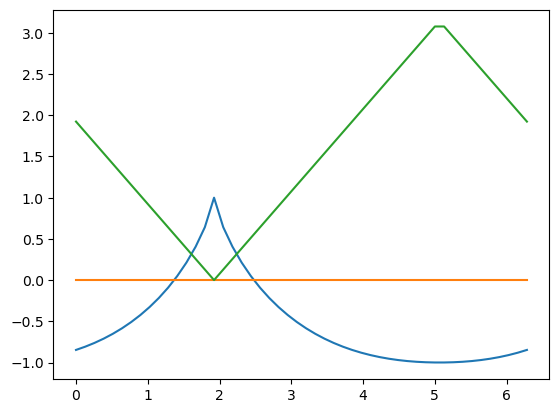

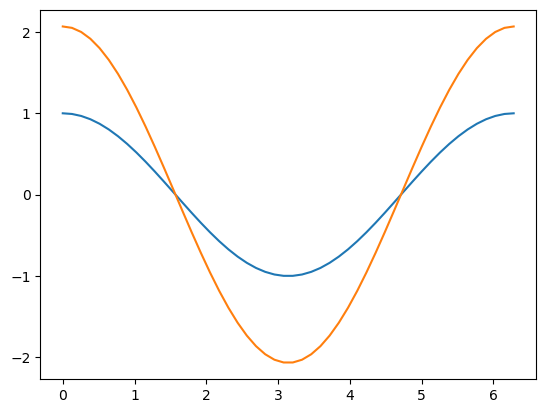

In [ ]:
import numpy as np
import torch 

def smallest_angle_to(curr_angle, targets):
    angles = curr_angle - targets
    abs_angle = torch.minimum(torch.absolute(angles), 2*torch.pi - torch.absolute(angles))
    return abs_angle

def smallest_angle_pw(angles1, angles2):
    pw_dif = angles1.unsqueeze(1) - angles2
    abs_angle = torch.minimum(torch.absolute(pw_dif), 2*torch.pi - torch.absolute(pw_dif))
    return abs_angle

# define a basic activation function
A = lambda theta: torch.cos(theta)
# angles between 0 and 2pi
thetas = torch.tensor(np.linspace(0, 2*np.pi))
theta_0 = thetas[15]
print(f"chosen angle: {theta_0:.3f}")
nu = 0.4

int_func = lambda theta, thetas: torch.cos(torch.pi*(smallest_angle_pw(theta, thetas)/torch.pi)**nu )
res = torch.trapz(int_func(thetas, thetas)*A(thetas),thetas)
plt.plot(thetas, torch.cos(torch.pi*(smallest_angle_to(theta_0, thetas)/torch.pi)**nu ))
plt.plot([thetas[0], thetas[-1]], [0,0])
plt.plot(thetas,smallest_angle_to(theta_0, thetas))


plt.show()
plt.plot(thetas, A(thetas))
plt.plot(thetas, res)
plt.show()

In [ ]:

int_func = lambda theta, thetas: torch.cos(torch.pi*(smallest_angle_pw(theta, thetas)/torch.pi)**nu )
A = lambda theta: theta*(1-theta/(2*torch.pi))

A_t = [A]
for i in range(2):
    A = A_t[i] 
    deriv = lambda theta: torch.trapz(int_func(theta, thetas)*A(thetas))
    dt = 0.01
    A_t.append( lambda theta: A(theta) + dt*deriv(thetas))

plt.plot(thetas,A_t[-1](thetas))



KeyboardInterrupt



In [ ]:
class AgentNet(nn.Module):
    ''' Neural Network for the decision making of the agent.'''

    # Idea: Each neuron gets a certain range of angles in which it gets activated whenever there is at least one target in this range
    # At first I will try the following simple idea:

    def __init__(self, params:Param_Agent) -> None:
        super().__init__()
        self.input_size = params.n_neurons 
        self.layer1 = nn.Linear(self.input_size, self.input_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        '''x will be the last inputs, multiplied by the target acitvations'''
        x = self.layer1(x)
        x = self.activation(x)
        return x
    

                  
class Neuron():
    def __init__(self, pref_angle, activation_width) -> None:
        self.pref_angle = pref_angle
        
        normal_std = activation_width
        self.activation_func = lambda theta: 1/(normal_std*np.sqrt(2*np.pi))*torch.exp(-1/2*(theta/normal_std)**2)
        self.max_base_activation = torch.max(self.activation_func(torch.tensor(np.linspace(0, 2*np.pi))))
        self.activation = 0

    def activate(self, targets: torch.Tensor):
        # find the closest angles between neuron preferred angle and targets
        self.activation =torch.max(self.activation_func(self.smallest_angle_to(targets)))/(0.5*self.max_base_activation)
        return self.activation

    def smallest_angle_to(self, targets):
        angles = self.pref_angle - torch.angle(targets)
        abs_angle = torch.minimum(torch.absolute(angles), 2*torch.pi - torch.absolute(angles))
        return abs_angle

    